## 0.1. Software imports

In [2]:
batch = 'Woodstar'
die = '11'
subdie = '7'
qubit_box = 'QBB36_1_3-left'
sample_name = 'IMEC-'+batch+'_Die'+die+'_Subdie'+subdie+'_'+qubit_box

In [3]:
import os 
#import sys 
#import copy 
#from functools import partial 
import importlib 

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.cm as cmx

import pandas as pd

import broadbean as bb
import broadbean.plotting
#from broadbean.plotting import plotter

import qcodes as qc 
from qcodes import load_by_id
from qcodes.dataset.plotting import plot_by_id, plot_dataset
from qcodes.utils.dataset.doNd import do0d, do1d, do2d

import qcodes.dataset.experiment_container as exc
from qcodes import initialise_database, Measurement, load_by_id, \
    initialise_or_create_database_at, load_or_create_experiment

from qcodes.instrument_drivers.AlazarTech.ATS9440 import AlazarTech_ATS9440
from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
from qdev_wrappers.alazar_controllers.AlazarAcquisitionController import AlazarAcquisitionController

## 0.2. Connect to Alazar card

In [4]:
alazar_card = AlazarTech_ATS9440(name='Alazar_ATS9440')

In [72]:
import qdev_wrappers.alazar_controllers.AlazarAcquisitionController
importlib.reload(qdev_wrappers.alazar_controllers.AlazarAcquisitionController)
from qdev_wrappers.alazar_controllers.AlazarAcquisitionController import AlazarAcquisitionController

In [73]:
acquisition_controller = AlazarAcquisitionController(alazar_name='Alazar_ATS9440', 
                                                     name='acquisition_controller_with_tektronix_awg',
                                                     awg=awg, 
                                                     average_buffers=False,
                                                     average_records=False,
                                                     integrate_samples=False)

## 0.3. Connect to Tektronix AWG 

In [8]:
awg = Tektronix_AWG5014('TektronixAWG', 'TCPIP0::192.168.15.128::inst0::INSTR', timeout=40)

Connected to: TEKTRONIX AWG5014C (serial:B010110, firmware:SCPI:99.0 FW:4.1.1.5) in 0.15s


## 0.4. Set up database

In [9]:
data_path = os.path.join('F:\\', 'qcodes_local', 'Sofia', 'IMEC', 'Woodstar', 
    '9.3. T-gate JellyBean with SET', 'Die11_Subdie7_QBB36_1_3', 'Week 5')

In [10]:
sample_name = 'no-sample'
initialise_or_create_database_at(os.path.join(data_path, 'Experiment databases', 
    sample_name+'_2022_04_06_tektronix_testing_with_alazar_card.db'))

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 500.33it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 500.39it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 250.17it/s]


In [ ]:
sample_name = 'no-sample'
initialise_or_create_database_at(os.path.join(data_path, 'Experiment databases', 
    sample_name+'_2022_04_06_tektronix_testing_with_alazar_card.db'))

## 1. Set up example pulse sequence from tektronix 

In [11]:
# # 
# # Empty - load - read -pulse sequence 
ELM = bb.PulseAtoms.ramp 

# # 
# # Pulse parameters 
t_empty = 10e-3
t_load = 10e-3
t_measure = 5e-3
num_steps = 101 # 

voltage_attenuation = 1/8.93 
VPP_at_device = 0.006 # V
VPP_at_AWG = VPP_at_device/voltage_attenuation # V

pulse_blue_print = bb.BluePrint()
pulse_blue_print.insertSegment(0, ELM, (-VPP_at_AWG/2, -VPP_at_AWG/2), dur=t_empty)
pulse_blue_print.insertSegment(1, ELM, (VPP_at_AWG/2, VPP_at_AWG/2), dur=t_load)
pulse_blue_print.insertSegment(2, ELM, (0, 0), dur=t_measure, name='varyme')

# # 
# # AWG parameters  
sample_rate = 1e7
marker_duration = 1e-3
pulse_blue_print.setSegmentMarker('varyme', (0, marker_duration), 1)  # segment name, (delay, duration), markerID
pulse_blue_print.setSR(sample_rate)

broadbean_element = bb.Element()
broadbean_element.addBluePrint(1, pulse_blue_print)

# # 
# # Check pulse consistency 
broadbean_element.validateDurations()  # raises an ElementDurationError if something is wrong. If all is OK, does nothing.
print('Designated channels: {}'.format(broadbean_element.channels))
print('Total duration: {} s'.format(broadbean_element.duration))
print('Sample rate: {} (Sa/S)'.format(broadbean_element.SR))

Designated channels: [1]
Total duration: 0.025 s
Sample rate: 10000000.0 (Sa/S)


C:\Users\T4ACQ\miniconda3\envs\livestream\lib\site-packages\broadbean\sequence.py:181: UserWarning: Deprecation warning. This function is only compatible with AWG5014 output and will be removed. Please use the specific setSequencingXXX methods.
  warnings.warn('Deprecation warning. This function is only compatible '


True

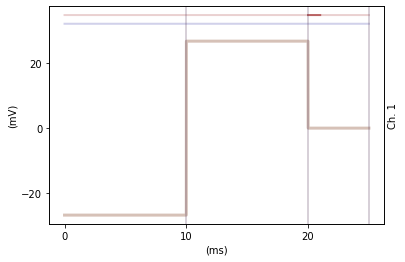

In [14]:
broadbean_sequence = bb.Sequence()
broadbean_sequence.setSR(sample_rate)
broadbean_sequence.addElement(1, broadbean_element)
broadbean_sequence.setSequenceSettings(1, 0, 1, 0, 0)

# Plot 
broadbean.plotting.plotter(broadbean_sequence)

broadbean_sequence.checkConsistency() 

In [15]:
broadbean_sequence.checkConsistency() 

True

In [16]:
# # 
# # Sequence for varying Vmeasure
poss = [1, 1] # ? 
channels = [1, 1]
names = ['varyme', 'varyme']
args = ['start', 'stop']
Vmeasure_steps = np.linspace(VPP_at_AWG/2,-VPP_at_AWG/2, num_steps)
iters = [Vmeasure_steps, Vmeasure_steps]
ELM_with_Vmeasure_steps = bb.repeatAndVarySequence(broadbean_sequence, poss, channels, names, args, iters)

ELM_with_Vmeasure_steps.checkConsistency()

True

In [17]:
ELM_with_Vmeasure_steps.setChannelAmplitude(1, 14)  # Call signature: channel, amplitude (peak-to-peak)
ELM_with_Vmeasure_steps.setChannelOffset(1, 0)

for i in range(num_steps-1):
    ELM_with_Vmeasure_steps.setSequencingTriggerWait(i+1, 0)
    ELM_with_Vmeasure_steps.setSequencingNumberOfRepetitions(i+1, 1)
    ELM_with_Vmeasure_steps.setSequencingEventJumpTarget(i+1, 0)
    ELM_with_Vmeasure_steps.setSequencingGoto(i+1, i+2)
ELM_with_Vmeasure_steps.setSequencingGoto(i+2, 1)

# # 
# # Output AWG file 
awg_file = ELM_with_Vmeasure_steps.outputForAWGFile()

In [18]:
awg.make_send_and_load_awg_file(*awg_file[:])

In [19]:
awg.clock_freq(sample_rate)
awg.ch1_state(1)
awg.run()

#awg.stop()
#awg.ch1_state(0)

'Running'

In [60]:
awg.stop()

## 2. Set up Alazard card ready for acquisition

In [78]:
acquisition_time = t_empty + t_load + t_measure # replace with pulse period 
samples_per_record = 1001 # samples per channel 

acquisition_kwargs = {'mode': alazar_card.mode(),
                      'records_per_buffer': num_steps,
                      'buffers_per_acquisition': 1,
                      'channel_selection': 'ABCD',
                      'buffer_timeout': 10000}

alazar_kwargs = {'channel_range': 0.2, 
                 'timeout_ticks': 10000,
                 'external_trigger_range': 'ETR_5V', 
                 'trigger_level1': 140} # 148
acquisition_controller.setup_acquisition(acquisition_time, samples_per_record, acquisition_kwargs=acquisition_kwargs, alazar_kwargs=alazar_kwargs)

In [75]:
acquisition_controller.acquisition_config

{'mode': 'NPT',
 'samples_per_record': 1280,
 'records_per_buffer': 50,
 'buffers_per_acquisition': 1,
 'channel_selection': 'ABCD',
 'transfer_offset': None,
 'external_startcapture': None,
 'enable_record_headers': None,
 'alloc_buffers': None,
 'fifo_only_streaming': None,
 'interleave_samples': None,
 'get_processed_data': None,
 'allocated_buffers': None,
 'buffer_timeout': 10000,
 'pack_mode': None}

In [76]:
print("sample rate: ", alazar_card.sample_rate())

print("channel indices: ",acquisition_controller.channel_indices.get())

print("time setpoints: ", acquisition_controller.time_setpoints.get())

sample rate:  50000
channel indices:  [0. 1. 2. 3.]
time setpoints:  [0.00000000e+00 2.00156372e-05 4.00312744e-05 ... 2.55599687e-02
 2.55799844e-02 2.56000000e-02]


## 3. Acquire data

In [79]:
data = acquisition_controller.dataset_acquisition()

In [80]:
experiment_name = 'test_dataset_acquisition'
experiment_name += '_tektronix_awg_ELM_with_VM_steps'
print(experiment_name)

exp = exc.load_or_create_experiment(experiment_name, 
    sample_name=sample_name)

test_dataset_acquisition_tektronix_awg_ELM_with_VM_steps


In [81]:
do0d(acquisition_controller.dataset_acquisition)

Starting experimental run with id: 1. 


(results #1@F:\qcodes_local\Sofia\IMEC\Woodstar\9.3. T-gate JellyBean with SET\Die11_Subdie7_QBB36_1_3\Week 5\Experiment databases\no-sample_2022_04_06_tektronix_testing_with_alazar_card.db
 --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 acquisition_controller_with_tektronix_awg_channel_indices - array
 acquisition_controller_with_tektronix_awg_buffer_indices - array
 acquisition_controller_with_tektronix_awg_record_indices - array
 acquisition_controller_with_tektronix_awg_time_setpoints - array
 acquisition_controller_with_tektronix_awg_dataset_acquisition - array,
 [None],
 [None])

In [82]:
dataset = load_by_id('1')
df = dataset.to_pandas_dataframe()

Text(0, 0.5, 'Channel A voltage (V)')

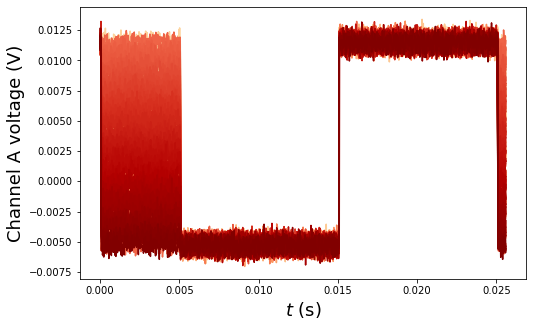

In [83]:
channel_names = ['A', 'B', 'C', 'D']
i_channel = 0
i_buffer = 0

fig, axs = plt.subplots(1,1, figsize=(8,5))
for i_record in range(num_steps):
    axs.plot(df.loc[(i_channel, i_buffer, i_record), :], color=cmx.OrRd(0.25 + 0.75*i_record/num_steps)) # each can also be slice(start_index, stop_index)

axs.set_xlabel('$t$ (s)', fontsize=18)
axs.set_ylabel('Channel '+channel_names[i_channel]+' voltage (V)', fontsize=18)

Text(0, 0.5, 'Channel B voltage (V)')

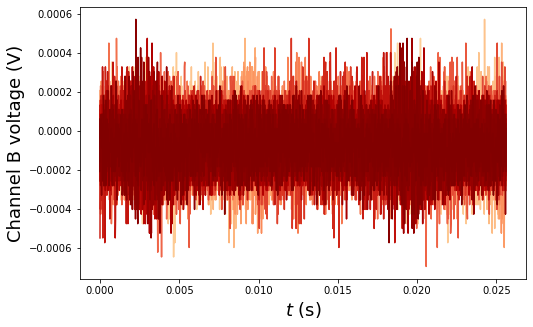

In [84]:
channel_names = ['A', 'B', 'C', 'D']
i_channel = 1
i_buffer = 0

fig, axs = plt.subplots(1,1, figsize=(8,5))
for i_record in range(num_steps):
    axs.plot(df.loc[(i_channel, i_buffer, i_record), :], color=cmx.OrRd(0.25 + 0.75*i_record/num_steps)) # each can also be slice(start_index, stop_index)

axs.set_xlabel('$t$ (s)', fontsize=18)
axs.set_ylabel('Channel '+channel_names[i_channel]+' voltage (V)', fontsize=18)